In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import time


In [3]:
# %% dataset : CIFAR10 (télécharge les images dans le dossier data)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train set into a train and validation sets
train_size = int(0.75*len(train_data))
valid_size = len(train_data) - train_size
torch.manual_seed(0)
train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, valid_size])

# nom des classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:31<00:00, 5.47MB/s]


=== train_data taille : 37500
=== valid_data taille : 12500
=== test_data taille : 10000


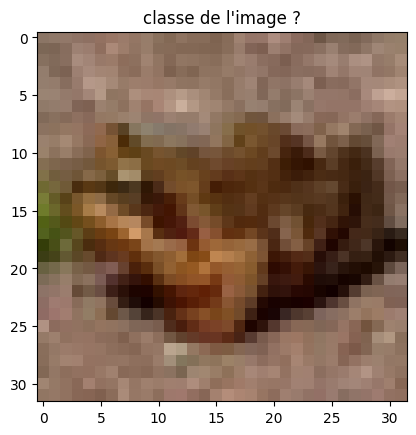

=== image est de type : <class 'torch.Tensor'>
=== taille du tenseur : torch.Size([3, 32, 32])
=== label 6


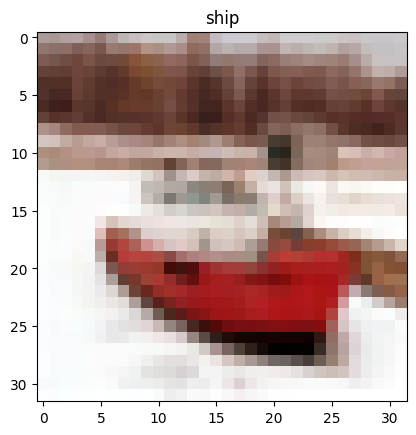

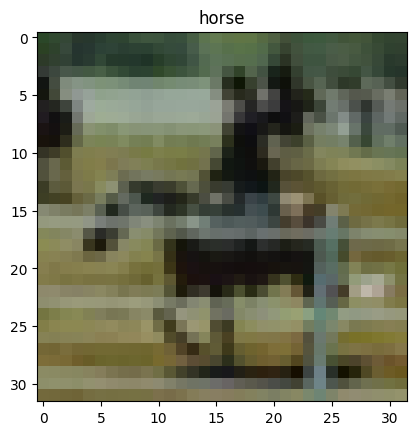

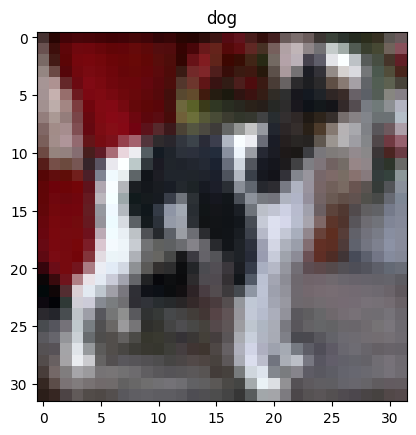

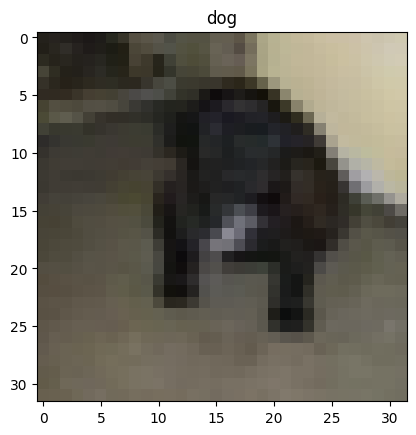

In [4]:
# %% comprendre les données

#------------------- A FAIRE : afficher la taille des 3 datasets
print("=== train_data taille :", len(train_data))
print("=== valid_data taille :", len(valid_data))
print("=== test_data taille :", len(test_data))
#-------------------

def print_image(image, title="classe de l'image ?"):
    image = image / 2 + 0.5     # unnormalize
    npimg = image.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


# -- visualiser la 1ère image de train_data
image, label = train_data[0]
print_image(image)
print("=== image est de type :", type(image))
print("=== taille du tenseur :", image.shape)
print("=== label", label)


#------------------- A FAIRE : visualiser les 5 premières images AVEC le nom de sa classe
for i in range(1, 5):
    image, label = train_data[i]
    title = classes[label]
    print_image(image, title)
#-------------------


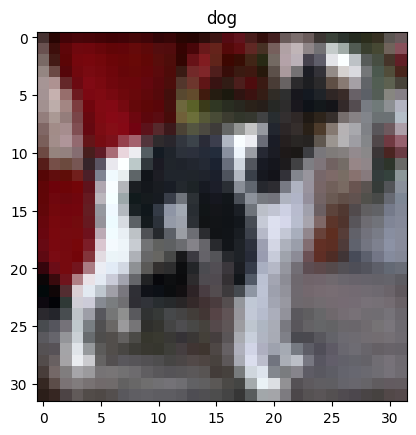

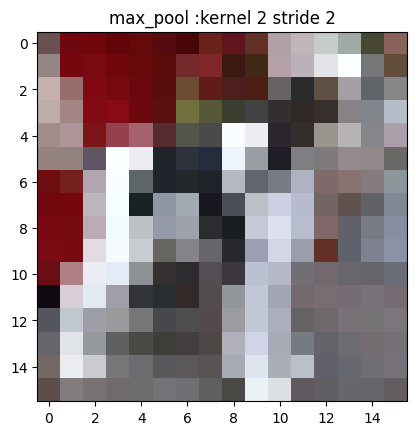

In [5]:
# %% modèle CNN
import torch.nn as nn
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

#------------- A FAIRE: comprendre max_pool2d
KERNEL = 2
STRIDE = 2
image, label = train_data[3]
print_image(image, classes[label])
image = F.max_pool2d(image, KERNEL, STRIDE)
print_image(image, "max_pool :kernel %i stride %i" % (KERNEL, STRIDE))
#-------------

In [6]:
# %% data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))
test_loader = DataLoader(valid_data, batch_size=len(test_data))


=== DEVICE = CUDA
epoch 0 train 2.30e+00  valid 2.29e+00 elapsed_time 1.56e+01
epoch 1 train 2.25e+00  valid 2.14e+00 elapsed_time 1.51e+01
epoch 2 train 2.05e+00  valid 1.96e+00 elapsed_time 1.49e+01
epoch 3 train 1.88e+00  valid 1.82e+00 elapsed_time 1.44e+01
epoch 4 train 1.75e+00  valid 1.71e+00 elapsed_time 1.43e+01
epoch 5 train 1.64e+00  valid 1.60e+00 elapsed_time 1.46e+01
epoch 6 train 1.56e+00  valid 1.54e+00 elapsed_time 1.40e+01
epoch 7 train 1.50e+00  valid 1.49e+00 elapsed_time 1.52e+01
epoch 8 train 1.46e+00  valid 1.46e+00 elapsed_time 1.89e+01
epoch 9 train 1.42e+00  valid 1.42e+00 elapsed_time 1.43e+01
epoch 10 train 1.38e+00  valid 1.38e+00 elapsed_time 1.48e+01
epoch 11 train 1.34e+00  valid 1.35e+00 elapsed_time 1.42e+01
epoch 12 train 1.31e+00  valid 1.32e+00 elapsed_time 1.49e+01
epoch 13 train 1.27e+00  valid 1.29e+00 elapsed_time 1.46e+01
epoch 14 train 1.24e+00  valid 1.29e+00 elapsed_time 1.45e+01
epoch 15 train 1.22e+00  valid 1.25e+00 elapsed_time 1.50e+01


Text(0.5, 0, 'epochs')

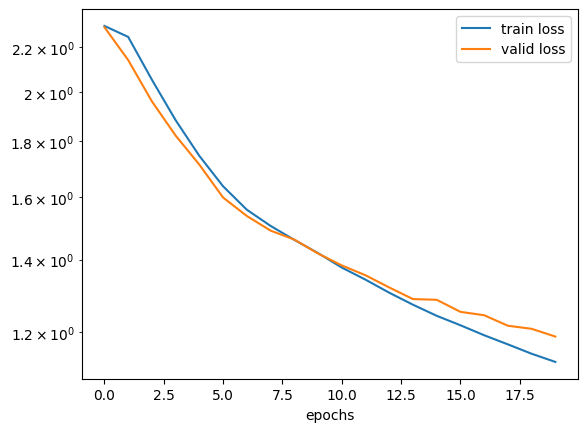

In [7]:
# %% entrainement

# hyperparamètres
#------------- A MODIFIER
LEARNING_RATE = 1e-3 / 2
EPOCHS = 20
USE_CUDA = True
#-------------

if USE_CUDA and torch.cuda.is_available():
    device = torch.device("cuda")
    print("=== DEVICE = CUDA")
else:
    device = torch.device("cpu")
    print("=== DEVICE = CPU")
model = model.to(device)


optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9) # optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_losses, valid_losses = [], [] # for each epoch
for epoch in range(EPOCHS):
    tic = time.time()
    # entrainement
    losses = []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # evaluer fonction cout
        labels_predict = model(images)
        loss = F.cross_entropy(labels_predict, labels)
        losses.append(loss.item())

        # mise à jour paramètre
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = np.mean(losses)
    train_losses.append(train_loss)

    # validation
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            labels_predict = model(images)
            valid_loss = F.cross_entropy(labels_predict, labels).item()
            valid_losses.append(valid_loss)

    # afficher progression
    elapsed_time = time.time () - tic
    print('epoch %i train %.2e  valid %.2e elapsed_time %.2e' % (epoch, train_loss, valid_loss, elapsed_time))


# tracer les courbes de progression train/valid
plt.semilogy(train_losses)
plt.semilogy(valid_losses)
plt.legend(['train loss', 'valid loss'])
plt.xlabel("epochs")

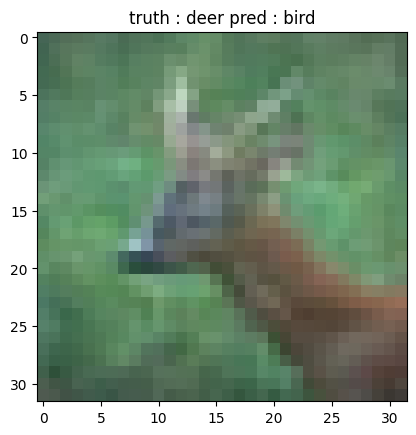

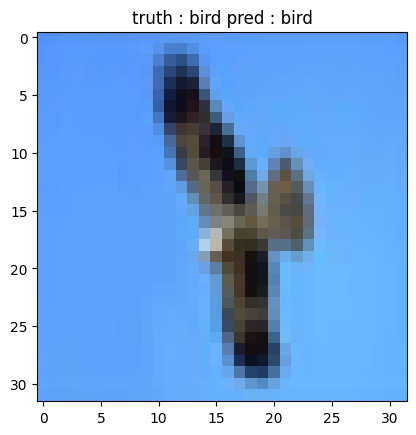

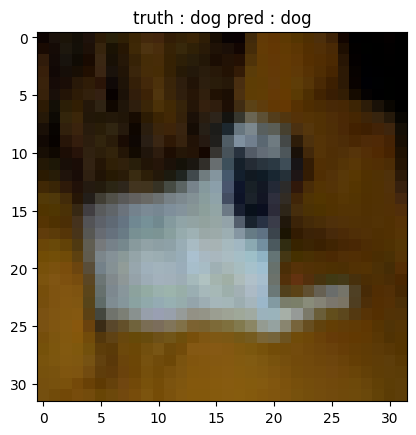

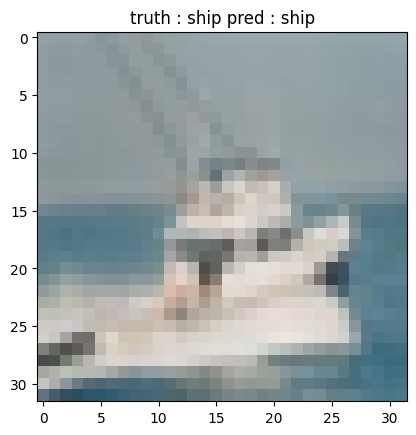

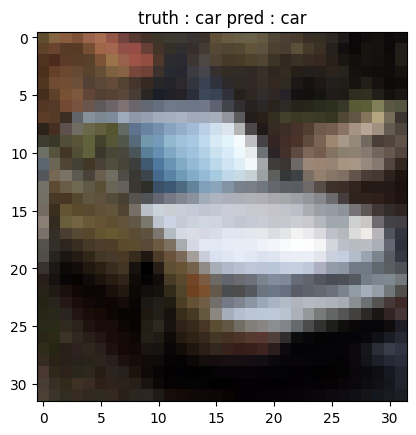

In [8]:
#%% tester le modèle sur les données de test

dataiter = iter(test_loader)
batch_images, batch_labels = next(dataiter)
outputs = model(batch_images.to(device))
_, predicted = torch.max(outputs, 1)

# print 5 images
for i in range(5):
  image, label = batch_images[i], batch_labels[i]
  truth = classes[label]
  pred = classes[predicted[i]]
  title = "truth : %s pred : %s" % (truth, pred)
  print_image(image, title)
